# Regression

Regression attempts to fit a function model to training data. Let's create a data set from a function, here $f = 3x^3 - 2x$, and add some Gaussian noise with standard deviation `sigma`:

In [1]:
import numpy as np

def generate_data(X, f=lambda x: 3*x**3 - 2*x, sigma=0.1):
    y = f(X) + np.random.normal(scale=sigma, size=X.shape)
    return y

X = np.linspace(-1,1,9)
y = generate_data(X)

X_test = np.linspace(-1, 1, 41)
y_test = generate_data(X_test, sigma=0.0)

### Visualize data

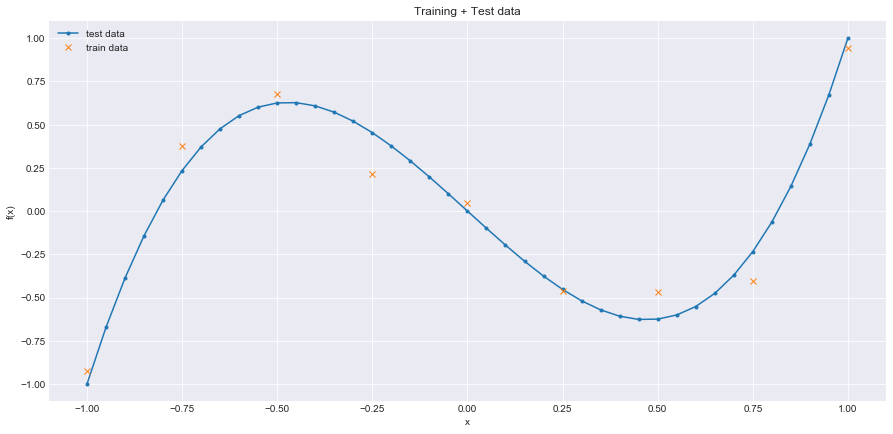

In [3]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('darkgrid')

plt.figure(figsize=(15,7))
plt.title("Training + Test data")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(X_test, y_test, ".-", label="test data")
plt.plot(X, y, 'x', label="train data")
plt.legend()
plt.show()

## Task 1: Polynomial function fitting

Augment the following code snippet to actually compute the nonlinear regression given the first $1..M$ training data points and considering a polynomial model of degree $P \in \{0..8\}$.  
What do you expect as optimal parameter values $w_0$ to $w_3$ for a polynomial model of degree $P=3$?

A: Optimal paramters for $w_0$ to $w_3$ would mimic the given polynomial model function $f = 3x^3 - 2x$ in this case, i.e.:
\begin{align}
    w_3 &= 3 \\
    w_2 &= 0 &&\text{(no quadratic term)}\\
    w_1 &= -2 \\
    w_0 &= 0 &&\text{(no constant term)}
\end{align}

In [4]:
class Regression:
    def __init__(self, alpha=0.0):
        self.w = np.zeros(0)
        self.alpha = alpha

    def predict(self, X):  # apply prediction model to data X
        return np.dot(X, self.w)

    def fit(self, X, y):  # compute optimal weights for training data (X,y)
        self.w = np.linalg.inv(X.T.dot(X) + self.alpha*np.eye(X.shape[1])).dot(X.T.dot(y))

In [5]:
from matplotlib import pyplot as plt
from ipywidgets import interact

# @interact makes the following function (update) interactive, with sliders for M and P
@interact(M=(1, len(X)), P=(0, 8), alpha=(-10.0, 10.0, 1.0))
def update(M=len(X), P=3, alpha=-10.0):
    def design_matrix(X):  # compute polynomial features
        return np.power(np.transpose([X]), range(0, P+1))
    
    # train regression model
    reg = Regression(alpha=10**alpha)  # use exponential mapping for alpha
    reg.fit(design_matrix(X[0:M]), y[0:M])  # fit the first M training points only
    print('w: ', reg.w)

    plt.figure(42, figsize=(15,7))
    plt.plot(X_test, y_test, '.-', label="test data")  # plot ground truth of test data
    plt.plot(X_test, reg.predict(design_matrix(X_test)), 'r-', label="prediction")  # plot model prediction on test data
    plt.scatter(X[0:M], y[0:M], marker='x', label="train data") # plot training data
    plt.legend()
    plt.show()

## Task 2

Explain, what is learned in the following situations:

1. $M=9$, $P=0$
2. $M=4$, $P=3$
3. $M=9$, $P=8$

1. $M=9$, $P=0$

In this case, _all_ 9 data points from $\mathbf{X}$ are used for training. Due to $P=0$ we only can model a $0$th order polynomial, i.e. a constant function.  
$\mathbf{X}$ reduces to a vector of ones: $\mathbf{X}=[1,1,1,1,1,1,1,1,1]^t$. Hence the normal equation of regression computes:
\begin{align}
  \mathbf{X}^t \cdot \mathbf{X} &= \sum_i 1^2 = 9 \\
  \mathbf{X}^t \cdot \mathbf{y} &= \sum_i 1 \cdot y_i \\
  (\mathbf{X}^t \cdot \mathbf{X})^{-1} \mathbf{X}^t \cdot \mathbf{y} &= \frac{1}{9} \sum_i y_i
\end{align}
Hence, the level of the constant function is just the mean of all training values $y_i$.

w:  [ 0.00068283]


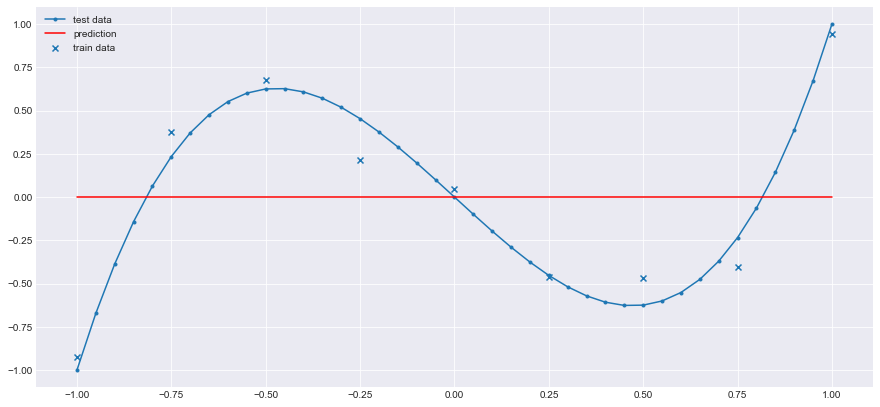

In [6]:
update(M=len(X), P=0, alpha=-10.0)

2. $M=4$, $P=3$

In this case, we only consider the first $M=4$ samples from our training data $\mathbf{X}$. $P=3$ implies a polynomial of $3$rd degree, i.e. functions $f(x) = w_3 x^3 + w_2 x^2 + w_1 x + w_0$.  
We know, that a polynomial of $n$th degree can be perfectly fitted through any (non-identical) $n+1$ data points.  
Hence the regression solution perfectly fits the first $4$ data points, but performs poorly on the remaining ones.

w:  [-0.76152268 -4.6247852  -2.20018534  2.58659508]


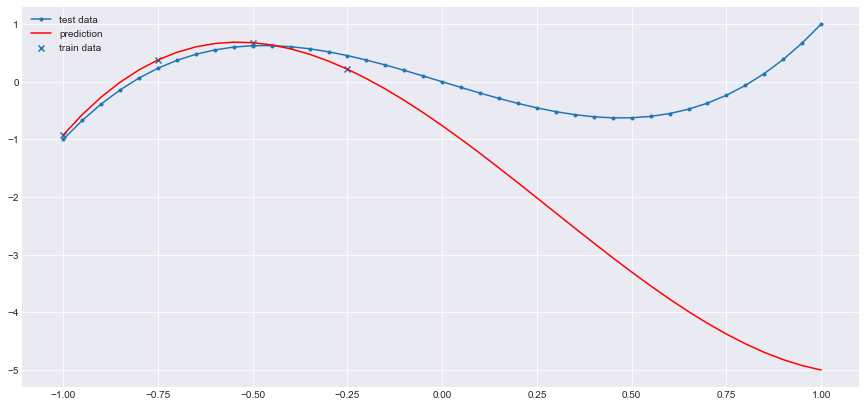

In [7]:
update(M=4, P=3, alpha=-10.0)

3. $M=9$, $P=8$

Finally, we utilize all $M=9$ sample points for training and fit a high-order polynomial of degree $P=8$.  
Again, we know that this polynomial can perfectly fit all our 9 training points, i.e. reduce the MSE on our training set to zero.  
Well, that sounds good, but what we are actually interested in the generalization error, which isn't that good at all.  
This is what is known as ***overfitting***: the model can perfectly describe the training data but it doesn't generalize well on test data.  
Due to the noisy inputs, a good model would actually accept some errors on the training data to gain better results on test samples.  

w:  [  4.45609022e-02  -1.39567844e+00  -4.47038456e+00   5.66629695e-01
   3.29448510e+01   1.74734205e+00  -6.56591625e+01   1.52039166e-02
   3.71501144e+01]


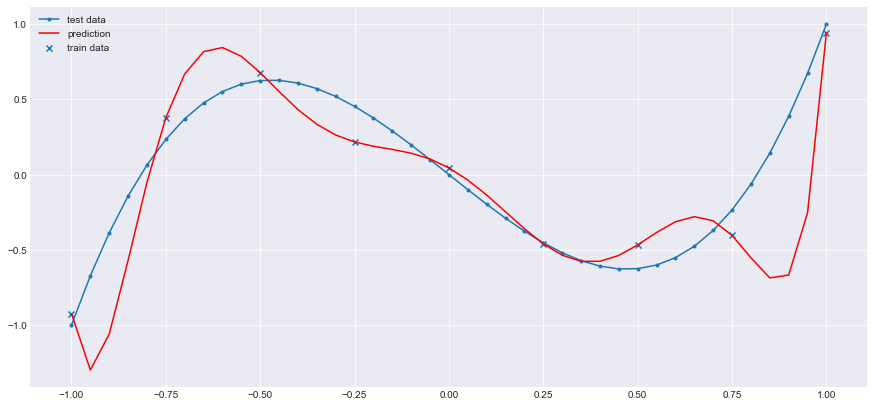

In [8]:
update(M=9, P=8, alpha=-10.0)

## Task 3: Ridge Regression

To improve the smoothness of the learned function model, we can use Ridge regression, which adds a regularization term to our cost function:

${\cal L} = \frac{1}{M} \|\hat{\mathbf y} - \mathbf y\|^2 + \lambda \|\mathbf w\|^2$

Show and verify step by step that the minimization of this loss functions yields the learning rule of Ridge regression:

$\mathbf w^* = (\mathbf X^t \mathbf X + \lambda \mathbf 1)^{-1} \mathbf X^t \mathbf y$

_Hint_: See [_The Matrix Cookbook_ (Petersen and Pedersen, 2012)](http://www2.imm.dtu.dk/pubdb/edoc/imm3274.pdf), for derivatives (section 2.4), norms (section 10.3) and other identities of vectors and matrices.

Extend your implementation to perform Ridge regression.  
Introduce $\lambda$ as a new parameter `alpha` to your `update` function and determine a suitable value for the case $P=8, M=9$ from task 2.  
Explain what happens for very large and very small values of $\lambda$.

According to the linear model, we have $\hat{\mathbf y} = \mathbf X \mathbf w$ and the loss becomes: ${\cal L} = \frac{1}{M} \|\mathbf X \mathbf w - \mathbf y\|^2 + \lambda \|\mathbf w\|^2$,  
where $\mathbf X \in \mathbb R^{M \times N}$ is the design matrix, $\mathbf y \in \mathbb R^{M}$ is the vector of all collected training targets $y^\alpha$, and $\mathbf w \in \mathbb R^N$ is the vector of weights.  
To compute the derivative of the loss with respect to $\mathbf w$, we need to compute the derivative of the squared norm and the matrix-vector product.  
According to [_The Matrix Cookbook_ (131)](http://www2.imm.dtu.dk/pubdb/edoc/imm3274.pdf#page=14) this can be computed as:
\begin{align}
\frac{\partial \|\mathbf x\|^2}{\partial \mathbf x} = \frac{\partial \mathbf x^t \mathbf x}{\partial \mathbf x} = 2 \mathbf x
\end{align}
However, they also neglect the fact that the derivative of a scalar function w.r.t. a vector-valued variable should be a _row_ vector.  
Going component-wise, we can easily derive the same result:
\begin{align}
  f(\mathbf x) &= \|\mathbf x\|^2 = \sum_j x_j^2 \\
  \frac{\partial f}{\partial x_i} &= \sum_j \frac{\partial}{\partial x_i} x_j^2 = \sum_j 2 \delta_{ij} x_j = 2 x_i
\end{align}

The derivative of $\mathbf X \cdot \mathbf w$ w.r.t. $\mathbf w$ can be computed as ([_The Matrix Cookbook_ (37, 33)](http://www2.imm.dtu.dk/pubdb/edoc/imm3274.pdf#page=9):  
\begin{align}
  \frac{\partial \mathbf X \cdot \mathbf w}{\partial \mathbf w} &= 
    \frac{\partial \mathbf X}{\partial \mathbf w} \cdot \mathbf w + 
    \mathbf X \cdot \frac{\partial \mathbf w}{\partial \mathbf w} \\
    &= \mathbf 0 + \mathbf X \cdot \mathbf 1 = \mathbf X
\end{align}

Again, we yield the same result from component notation:
\begin{align}
  \frac{\partial}{\partial w_k} (\mathbf X \cdot \mathbf w)_{i}
   &= \frac{\partial}{\partial w_k} \sum_j X_{ij} \cdot w_j
    = \sum_j \frac{\partial}{\partial w_k} X_{ij} \cdot w_j
    = \sum_j \delta_{kj} \cdot X_{ij}
    = X_{ik}
\end{align}

Combining both results according to the chain rule, we yield:
\begin{align}
  \frac{\partial}{\partial \mathbf w} \frac{1}{M} \|\mathbf X \mathbf w - \mathbf y\|^2 + \lambda \|\mathbf w\|^2
   &= \frac{2}{M} (\mathbf X \mathbf w - \mathbf y)^t \cdot \mathbf X \quad + \quad 2\lambda \cdot \mathbf w^t
\end{align}
Transposing this result and setting the gradient to zero (to solve for the minimum), we get:
\begin{align}
   \frac{2}{M} \mathbf X^t \cdot (\mathbf X \mathbf w - \mathbf y)  \quad + \quad 2\lambda \cdot \mathbf w &= \mathbf 0 \\
   \mathbf X^t \cdot \mathbf X \mathbf w - \mathbf X^t \cdot \mathbf y \quad + \quad \frac{\lambda}{M} \, \mathbf w &= \mathbf 0 \\
   (\mathbf X^t \cdot \mathbf X + \frac{\lambda}{M}) \cdot \mathbf w &= \mathbf X^t \cdot \mathbf y \\
   \mathbf w &= \left(\mathbf X^t \cdot \mathbf X + \frac{\lambda}{M}\right)^{-1} \, \mathbf X^t \cdot \mathbf y
\end{align}
If we skip the normalization of the squared error, i.e. set $M=1$, we yield: $\mathbf w^* = (\mathbf X^t \cdot \mathbf X + \lambda \mathbf 1)^{-1} \, \mathbf X^t \mathbf y$

For those, who like a componentwise derivation, here it is:
\begin{align}
  \frac{\partial {\cal L(\mathbf w)}}{\partial w_k} &= \frac{\partial}{\partial w_k} \|\mathbf X \cdot \mathbf w - \mathbf y\|^2 \\
  &= \frac{\partial}{\partial w_k} \sum_i \left( \sum_j X_{ij} w_j - y_i\right)^2 \\
  &= \sum_i 2 \left( \sum_j X_{ij} w_j - y_i\right) \cdot \frac{\partial}{\partial w_k} \left(\sum_j X_{ij} w_j\right) \\
  &= \sum_i 2 \left( \sum_j X_{ij} w_j - y_i\right) \cdot \left(\sum_j \delta_{kj} X_{ij} w_j\right) \\
  &= \sum_i 2 \left( \sum_j X_{ij} w_j - y_i\right) \cdot X_{ik} \\
  &= 2 \left(\sum_j \sum_i X_{ij} X_{ik} w_j \quad - \quad \sum_i X_{ik} y_i \right) \\
  &= 2 \left(\sum_j (\mathbf X^t \cdot \mathbf X)_{jk} w_j \quad - \quad (\mathbf X^t \cdot \mathbf y)_k \right) \\
  &= 2 \left((\mathbf X^t \cdot \mathbf X \cdot \mathbf w)_k \quad - \quad (\mathbf X^t \cdot \mathbf y)_k \right) \\
\end{align}

## Task 4: LASSO

Instead of using the L2 norm, i.e. the _squared_ Euclidean norm $\|\mathbf w\|_2^2 = \sum w_i^2$, one can also use the L1 norm, i.e. $\|\mathbf w\|_1 = \sum |w_i|$, as a regularization term.  
This results in LASSO regression (_least absolute shrinkage and selection operator_).

1. Replace your `Regression` instance with the [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso) regressor from [scikit-learn](https://scikit-learn.org):  
   ```python
   from sklearn.linear_model import Lasso
   ```  
   Compare the resulting weight vectors with those from Ridge regression. What do you observe?

2. Determine and sketch the derivatives of both norms w.r.t. $\mathbf w$.  
   What are the advantages and disadvantages of both regularization terms?

In [9]:
from sklearn.linear_model import Lasso

# @interact makes the following function (update) interactive, with sliders for M and P
@interact(M=(1, len(X)), P=(0, 8), alpha=(-10.0, 10.0, 0.1))
def update(M=len(X), P=8, alpha=-4.0):
    def design_matrix(X):  # compute polynomial features
        return np.power(np.transpose([X]), range(0, P+1))
    
    # train regression model
    reg = Lasso(alpha=10**alpha)  # use exponential mapping for alpha
    reg.fit(design_matrix(X[0:M]), y[0:M])  # fit the first M training points only
    print('w: ', reg.coef_)

    plt.figure(42, figsize=(15,7))
    plt.plot(X_test, y_test, '.-', label="test data")  # plot ground truth of test data
    plt.plot(X_test, reg.predict(design_matrix(X_test)), 'r-', label="prediction")  # plot model prediction on test data
    plt.scatter(X[0:M], y[0:M], marker='x', label="train data") # plot training data
    plt.legend()
    plt.grid()
    plt.show()

Ridge and Lasso regression are some basic regularization techniques to automatically reduce model complexity and prevent over-fitting, which may result from naive linear regression.  
In both cases, the penalty weight $\lambda$ balances between the original MSE term and the regularization term, which attempts to pull all weights to zero.   
Hence, in both cases the weights get reduced to smaller values. Intuitively, the difference between L2 and L1 penalization is that L2 penalizes weights > 1 much stronger, but weights < 1 less than the L1 norm.

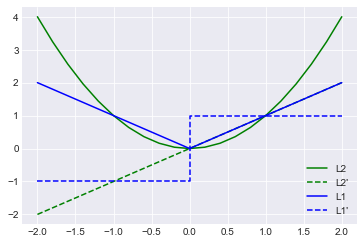

In [14]:
xs = np.concatenate([np.linspace(-2,-1e-8,11), np.linspace(1e-8,2,11)])
plt.plot(xs, xs**2, 'g-', label="L2")
plt.plot(xs, xs, 'g--', label="L2'")
plt.plot(xs, np.abs(xs), 'b-', label="L1")
plt.plot(xs, np.sign(xs), 'b--', label="L1'")
plt.legend();

**Ridge Regression** enforces smaller weights, but does not enforce irrelevant feature components to get assigned a weight of zero.

**Lasso**, or L1 penalization, on the other hand, actually enforces some weights to become zero - the more the larger the penalty weight $\lambda$ becomes.  
Hence, L1 penalization serves as a feature _selector_, only assigning non-zero weights to those features that are actually relevant for the task.  

Why do we get this surprising result? Let's consider the derivatives:
\begin{align}
  &\text{L2:}\quad &\frac{\partial}{\partial w_i} \|\mathbf w\|_2^2 &= 2 w_i \\
  &\text{L1:}\quad &\frac{\partial}{\partial w_i} \|\mathbf w\|_1 &= \operatorname{sign}(w_i)
  = \begin{cases} +1 & \text{if }w_i > 0 \\ \phantom{+}0 & \text{if }w_i = 0 \\ -1 & \text{if }w_i < 0 \end{cases}
\end{align}
Hence, while L2 norm's gradient changes smoothly around zero and weights are just push more gently towards zero if getting closer, L1 norm's gradient always pushes them with the same "force" of +1 or -1. If some weights get close to zero, the L1 term for them has a _stronger_ effect than the data error, thus pushing the weights towards zero, because only then the L1 term becomes zero.

There is a great video from Prof. Ihler illustrating the differences between these norms: https://www.youtube.com/watch?v=sO4ZirJh9ds